## import libraries 

In [18]:
import pandas
import configparser
import psycopg2

In [16]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [17]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the house table

make sure change the schema name to your gp number

In [19]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp16.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [5]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [20]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [21]:
url = 'https://www.trulia.com/IL/Carol_Stream/60188/'

In [23]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
print(html_data.decode('utf-8'))



<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><script>
            window.__uspapi = function(command, version, callback) {
              try {
                if (command === 'getUSPData') {
                  var cookies = document.cookie.split(';');
                  for (var i = 0; i < cookies.length; i++) {
                    var cookie = cookies[i];
                    var separatorIndex = cookie.indexOf('=');
                    separatorIndex = separatorIndex < 0 ? cookie.length : separatorIndex;
                    var cookie_name = decodeURIComponent(cookie.slice(0, separatorIndex).replace(/^\s+/, ''));
                    if (cookie_name === 'usprivacy') {
                      var uspString = decodeURIComponent(cookie.slice(separatorIndex + 1));
                      callback({ version: version, uspString: uspString }, true);
                      return;
                    }
                  }
                }
              } catch (ex) {
                c

In [25]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
print (soup)



<!DOCTYPE html>
<html lang="en"><head><meta charset="utf-8"/><script>
            window.__uspapi = function(command, version, callback) {
              try {
                if (command === 'getUSPData') {
                  var cookies = document.cookie.split(';');
                  for (var i = 0; i < cookies.length; i++) {
                    var cookie = cookies[i];
                    var separatorIndex = cookie.indexOf('=');
                    separatorIndex = separatorIndex < 0 ? cookie.length : separatorIndex;
                    var cookie_name = decodeURIComponent(cookie.slice(0, separatorIndex).replace(/^\s+/, ''));
                    if (cookie_name === 'usprivacy') {
                      var uspString = decodeURIComponent(cookie.slice(separatorIndex + 1));
                      callback({ version: version, uspString: uspString }, true);
                      return;
                    }
                  }
                }
              } catch (ex) {
                

## insert the records into database

In [26]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp16.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [27]:
df = pandas.read_sql_query('select * from gp16.house ', conn)
df[:10]

,price,bed,bath,area,address
0,319000,3,3,1579,"885 Napa St, Carol Stream, IL 60188"
1,359000,4,3,2066,"785 Burning Trl, Carol Stream, IL 60188"
2,319900,3,2,1445,"216 Carriage Dr, Carol Stream, IL 60188"
3,257000,3,2,1612,"25W715 Lies Rd, Carol Stream, IL 60188"
4,235000,3,2,1210,"781 Hoover Dr, Carol Stream, IL 60188"
5,330000,3,3,1680,"1N375 Farwell St, Carol Stream, IL 60188"
6,300000,3,2,1560,"848 Plains Ct, Carol Stream, IL 60188"
7,300000,3,2,1694,"752 Hickory Ln, Carol Stream, IL 60188"
8,249900,3,1,1416,"1299 Antigo Ln, Carol Stream, IL 60188"
9,280000,3,2,1458,"721 Hemlock Ln, Carol Stream, IL 60188"


## basic stat

In [28]:
df.describe()

,price,bed,bath,area
count,40.000000,40.000000,40.000000,40.000000
mean,294932.500000,3.000000,2.275000,1660.800000
std,101590.566863,0.784465,0.876693,585.950912
min,127500.000000,2.000000,1.000000,916.000000
25%,238675.000000,2.750000,2.000000,1287.750000
50%,284950.000000,3.000000,2.000000,1529.500000
75%,322425.000000,3.000000,3.000000,1814.500000
max,569900.000000,5.000000,4.000000,3300.000000


## price distribution

<AxesSubplot:>

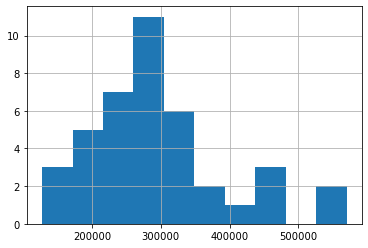

In [29]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

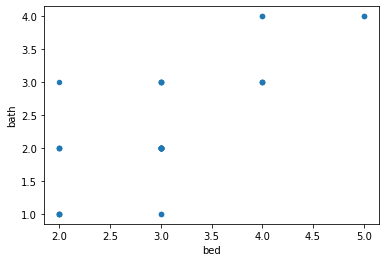

In [30]:
df.plot.scatter(x='bed',y='bath')